In [40]:
import numpy as np
from matplotlib import pyplot as plt
from ECG200Reader import get_train_data, get_test_data

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()
X_train.shape, y_train.shape

((100, 96), (100,))

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mm = MinMaxScaler()
ss = StandardScaler()

In [3]:
X_test_normed = ss.fit_transform(mm.fit_transform(X_test))
X_train_normed = ss.fit_transform(mm.fit_transform(X_train))

In [12]:
# 分别在原始数据集和新的数据集上训练(10次)
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

In [21]:
# 降维数据集
from sklearn.decomposition import PCA
pca = PCA(n_components=1-1e-4)
pca.fit(X_train_normed)
X_train_pca = pca.transform(X_train_normed)
opt_n_components = pca.n_components_
opt_n_components, X_train_pca.shape

(81, (100, 81))

In [22]:
pca = PCA(n_components=opt_n_components)
pca.fit(X_test_normed)
X_test_pca = pca.transform(X_test_normed)
X_test_pca.shape

(100, 81)

In [23]:
def dim_reduced(X_data, y_label):
    svm_clf = SVC(kernel='rbf')
    cross_val_score(svm_clf, X_data, y_label, cv=10)
    svm_clf.fit(X_data, y_label)
    y_pred = svm_clf.predict(X_test_pca)
    return f1_score(y_pred, y_test)
acc = 0
for i in range(10):
    acc += dim_reduced(X_train_pca, y_train)
acc/10

0.8333333333333333

In [25]:
# 原始数据集
def original(X_data, y_label):
    svm_clf = SVC(kernel='rbf')
    cross_val_score(svm_clf, X_data, y_label, cv=10)
    svm_clf.fit(X_data, y_label)
    y_pred = svm_clf.predict(X_test_normed)
    return f1_score(y_pred, y_test)
acc = 0
for i in range(10):
    acc += original(X_train_normed, y_train)
acc/10

0.9104477611940298

In [57]:
# KernelPCA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
ncs, f1sc = [], []

for nc in range(X_train.shape[1]):
    # 1. 降维
    pca = PCA(n_components=nc+1)
    try:
        pca.fit(X_train_normed)
    except ValueError:
        print(f"Expection with pc {nc+1}")
    else:
        X_train_pca = pca.transform(X_train_normed)
        pca.fit(X_test_normed)
        X_test_pca = pca.transform(X_test_normed)
        # 2. 训练svm
        svm_clf = SVC(kernel='rbf')
        # cross_val_score(svm_clf, X_train_pca, y_train, cv=10)
        svm_clf.fit(X_train_pca, y_train)
        # 3. 在训练集上求 f1-sco, 保存结果
        y_pred = svm_clf.predict(X_test_pca)
        ncs.append(nc+1)
        f1sc.append(f1_score(y_pred, y_test))
ncs = np.array(ncs)
f1sc = np.array(f1sc)
f1sc.max(), ncs[f1sc==f1sc.max()], f1sc.shape

(0.8527131782945736, array([7]), (96,))

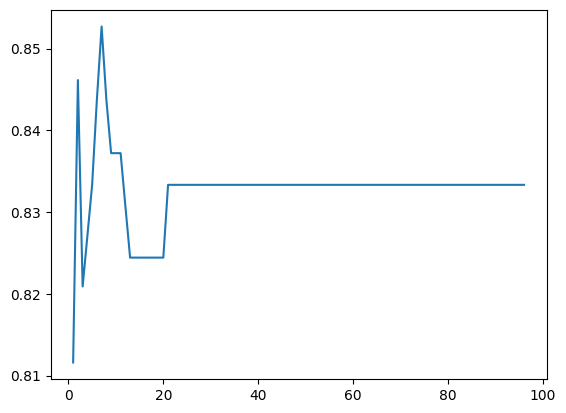

In [48]:
plt.plot(ncs, f1sc)